# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv5_4.

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='notebook_ims/style_tx_cat.png' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K

import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

2022-08-26 10:35:18.722854: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-26 10:35:18.921835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 10:35:18.921852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# LOAD IMAGE AND PREPROCESSING

In [4]:
content_image_path = "./test_data/content/janelle.png"
style_image_path = "./test_data/style/magritte.jpg"

In [5]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    image = image.resize((size, size))
    np_image = np.expand_dims(np.asarray(image), axis=0) / 255.0
        
    return np_image

def show_image(content_img, style_img=None):
    if (len(content_img.shape) > 3):
        content_img = np.squeeze(content_img)
    if (style_img is not None):
        if (len(style_img.shape) > 3):
            style_img = np.squeeze(style_img)
    
    plt.figure(figsize=(32, 16))
    plt.subplot(141)
    plt.imshow(content_img)
    if (style_img is not None):
        plt.subplot(142)
        plt.imshow(style_img)
    plt.show()

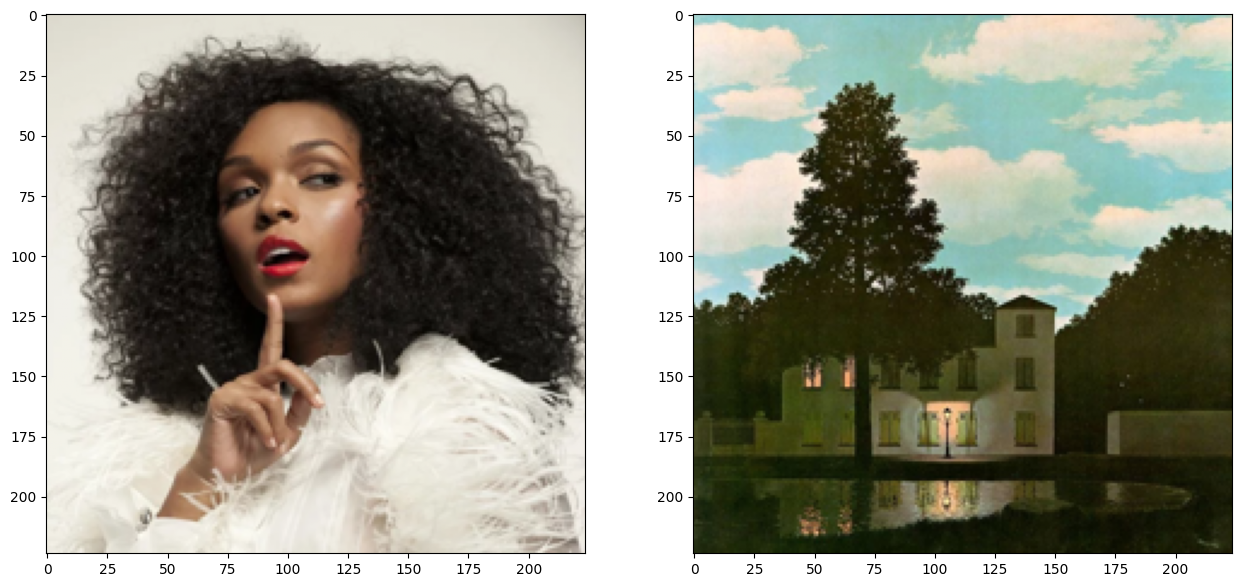

In [6]:
content_image = load_image(content_image_path, shape=224)
style_image = load_image(style_image_path, shape=224)
show_image(content_image, style_image)

# DEFINE MODEL AND TRAINING

### Load pre-trained VGG-16

In [95]:
# Load pre-trained VGG16 feature extractor (not including bottom dense layers) from keras
model = VGG16(weights='imagenet', include_top=False)
# Freeze all the layers because we only train the target image
for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [96]:
# Layers list to be extracted
layers_list = [1, 2, 7, 11, 15]

### Calculate gram-matrix for style 

In [97]:
def gram_matrix(tensor):
    # reshape tensor from (batch_size, w, h, filter) to (batch_size, w*h, filter)
    _, w, h, d = tensor.shape
    tensor = np.reshape(tensor, (-1, w * h, d))
    trans_tensor = np.transpose(tensor, axes=(0, 2, 1))
    
    # For notation in np.einsum: B is for Batch, N is for w*h, i is for d
    return np.einsum('BNi,BiN ->BN', tensor, np.transpose(tensor, axes=(0, 2, 1)))

### Get output of 5 Convolutional layers

In [98]:
def get_features(image, model, layers_list):
    outputs = [model.layers[layer].output for layer in layers_list]                 # all layer outputs
    # functor = K.function(model.input, outputs)   # evaluation function
    layer_outs = []
    for output in outputs:
        functor = tf.keras.Model(model.inputs,output)
        early_predict = functor(image)
        layer_outs.append(early_predict)                           # Testing
    return layer_outs

# Training

In [99]:
# Get content feature and style feature. These won't change throughout the training
content_feature = get_features(content_image, model, layers_list)
style_feature = get_features(style_image, model, layers_list)

In [117]:
# Create random image
target_image = np.copy(content_image)

# Training loop
epochs = 2000
show_every = 200
optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

# Style loss weight
style_loss_weights = [1.0, 0.8, 0.5, 0.3, 0.1]

# Style transfer loss weight
alpha = 1.0
beta = 1e7 * 1.0

In [118]:
target_image_tensor = tf.Variable(target_image, dtype=tf.float32)

def train_step():
    for i in range(epochs):
        # Get target feature
        style_transfer_loss = 0.0
        with tf.GradientTape() as tape:
            tape.watch(target_image_tensor)
            target_feature = get_features(target_image_tensor, model, layers_list)

            # Calculate content loss (mse in Conv4 layers)
            content_loss = mse_loss_fn(content_feature[4], target_feature[4])

            # Calculate style loss (mse in 5 Conv layers with weight)
            style_loss = 0.0
            for j, weight in enumerate(style_loss_weights):
                style_loss += weight * mse_loss_fn(gram_matrix(style_feature[j]), gram_matrix(target_feature[j]))

            style_transfer_loss += alpha * content_loss + beta * style_loss

        if (i % show_every == 0):
            style_transfer_loss_val = style_transfer_loss.numpy()
            print("Content loss: ", style_transfer_loss_val)
            show_image(content_image, target_image_tensor.numpy())

        grads = tape.gradient(style_transfer_loss, target_image_tensor)
        optimizer.apply_gradients(zip([grads], [target_image_tensor]))

Content loss:  420618700000000.0


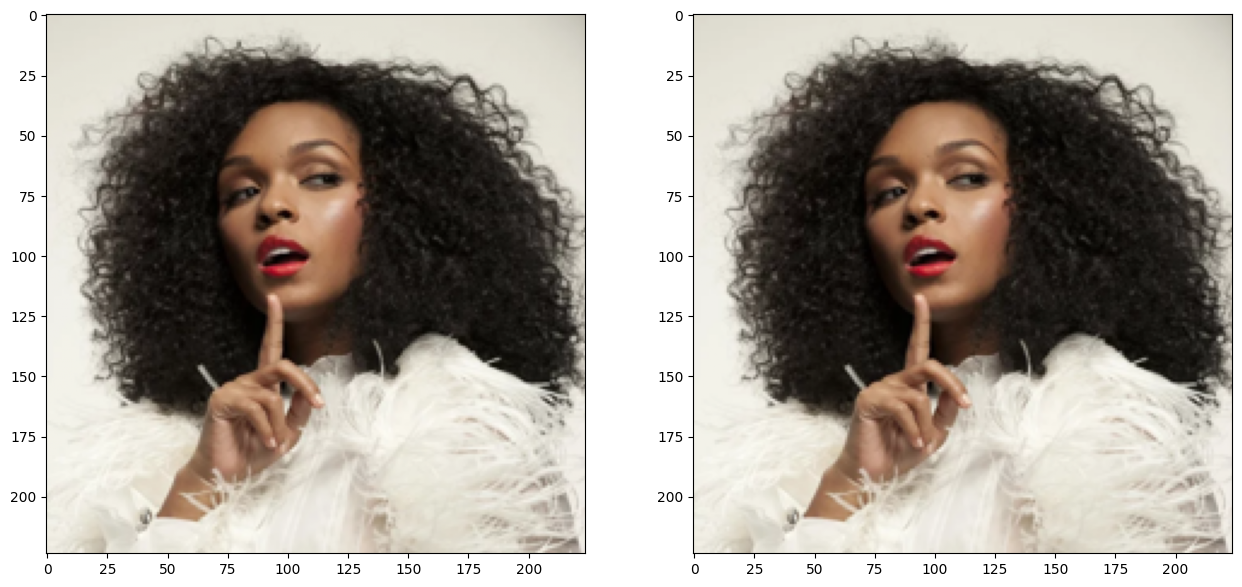

KeyboardInterrupt: 

In [119]:
train_step()